<a href="https://colab.research.google.com/github/freealise/freealise/blob/main/opencv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ffmpy
import IPython.display as display
from ffmpy import FFmpeg
ff = FFmpeg(
    inputs={'movie.mp4': None },
    outputs={'output.png': '-f apng -vf "chromakey=0xffffff:0.01:0.2"' }
)
ff.run()
ff = FFmpeg(
    inputs={'output.png': None},
    outputs={'output.gif': None}
)
ff.run()
video="output.gif"
display.display(display.Markdown(F"""![]({video})"""))

![](output.gif)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

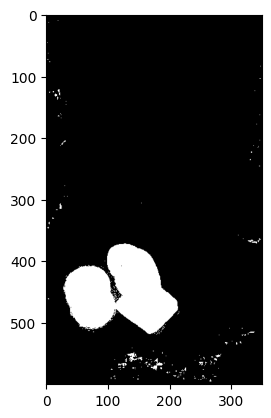

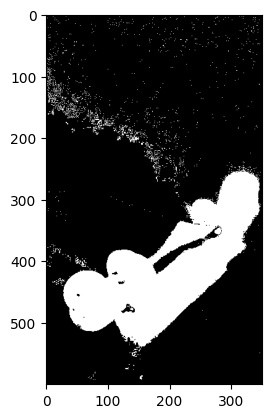

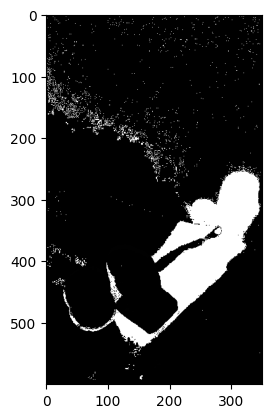

In [41]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

flash = cv.imread('_flash.jpg')
noflash = cv.imread('_noflash.jpg')

n = int((flash.shape[0]*flash.shape[1]) / (256*256))
flash_bg = cv.medianBlur(flash, 255)
noflash_bg = cv.medianBlur(noflash, 255)

for i in range(0, n):
  flash_bg = cv.medianBlur(flash_bg, 255)
  noflash_bg = cv.medianBlur(noflash_bg, 255)

flash_diff = cv.convertScaleAbs(flash.astype(np.int16)-flash_bg.astype(np.int16)).astype(np.uint8)
noflash_diff = cv.convertScaleAbs(noflash.astype(np.int16)-noflash_bg.astype(np.int16)).astype(np.uint8)

noflash_diff = cv.cvtColor(noflash_diff, cv.COLOR_BGR2GRAY)
flash_diff = cv.cvtColor(flash_diff, cv.COLOR_BGR2GRAY)

md = 12
flash_diff[flash_diff>=md] = 255
noflash_diff[noflash_diff>=md] = 255

flash_diff[flash_diff<md] = 0
noflash_diff[noflash_diff<md] = 0

cv.rectangle(noflash_diff,(0,0),(noflash_diff.shape[1]-1,noflash_diff.shape[0]-1),(255,255,255),1)
mask = cv.floodFill(noflash_diff, None, (0, 0), 255, 0, 0, (4 | cv.FLOODFILL_FIXED_RANGE))[2] #(4 | cv.FLOODFILL_FIXED_RANGE | cv.FLOODFILL_MASK_ONLY | 255 << 8)
# 255 << 8 tells to fill with the value 255)
mask = mask[1:mask.shape[0]-1, 1:mask.shape[1]-1]
noflash_diff[mask>0] = 0

cv.rectangle(flash_diff,(0,0),(flash_diff.shape[1]-1,flash_diff.shape[0]-1),(255,255,255),1)
mask = cv.floodFill(flash_diff, None, (0, 0), 255, 0, 0, (4 | cv.FLOODFILL_FIXED_RANGE))[2] #(4 | cv.FLOODFILL_FIXED_RANGE | cv.FLOODFILL_MASK_ONLY | 255 << 8)
# 255 << 8 tells to fill with the value 255)
mask = mask[1:mask.shape[0]-1, 1:mask.shape[1]-1]
flash_diff[mask>0] = 0

plt.imshow(flash_diff, 'gray')
plt.show()
plt.imshow(noflash_diff, 'gray')
plt.show()
plt.imshow(noflash_diff-flash_diff, 'gray')
